# Introduction

The aim of this project is to determine if the clients on the given database will make transactions again in the next two months. To achieve this, 6 tables will be used, containing data regarding transactions, demographics, behavior, finance, etc. The main platform to study is platform A (pa in the tables), which allows the user to save money, invest and pay for things or bills, etc; while also being closely related to platform B, which is a marketplace.

First, I am going to analyze the quality of the data in each table, fixing errors such as duplicates or null values (either removing or imputing them) and working with categorical features. Once fixed, we will build an input table to be used in the following sections.

Afterwards, I am going to do an exploratory data analysis to indentify key points that will help in achieving the main objective of this project. For this, I will check counts (independently and in relation to the response labels), variance, correlations, boxplots, distributions, and many more.

Lastly, I will start searching for a predictive model to determine if the client is going to churn or not. Three types of models will be used, while also trying to improve them by cross validating, parameter tuning and feature engineering.

So, before we start, here is the data dictionary regarding the tables.
   1. ACCOUNT_MONEY: Contains data about the amount of cash in the account and if the user is investing.
           a. cus_id: Customer ID.
           b. money_1: Amount of cash in the previous month (-1).
           c. money_2: Amount of cash in the previous two months (-2).
           d. investment: If the user is eligible to invest, is investing or not.
   2. ACTIVE_USER: Contains data about the visits to each app (for platforms A and B).
           a. cus_id: Customer ID.
           b. pa_n: Amounts of visits per month for platform A on the previous N month (either 1, 2 or 3).
           c. pb_n: Amounts of visits per month for platform B on the previous N month (either 1, 2 or 3).
           d. last_login_pa: Date of the last login for platform A in each month.
           e. last_login_pa: Date of the last login for platform B in each month.
   3. DEMOGRAPHICS: Contains demographic data about the users.
           a. cus_id: Customer ID.
           b. city.
           c. gender.
           d. age.
           e. pay_type: Type of payment they have access to (Credit/Debit/etc).
           f. province.
   4. EVALUATE: Contains the labels for each user. Used to test the models.
           a. cus_id: Customer ID.
           b. churn: if the user will stop using the platform in the next two months or not.
   5. MARKETPLACE_DATA: Summary of each users' transaction records on platform B on the last 6 months.
           a. cus_id: Customer ID.
           b. spent_pb: Amount of cash spent.
           c. last_date_pb: Date of the last purchase on the platform.
           d. frequency_pb: Amount of days each user made a purchase.
   6. PAYMENTS: Transactional data on platform A for each user.
           a. cus_id: Customer ID.
           b. date: Date of the transaction.
           c. cus_id_seller: Seller ID.
           d. spent_pa: Amount spent on the transaction.
           e. segment: Transaction type.
           f. discount_pa: Discount the buyer received on the transaction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from os import listdir
from os.path import isfile, join
from sklearn.experimental import enable_iterative_imputer # Needed for IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from datetime import datetime

In [2]:
## TABLE UTILS

def read_files(path):
    '''
    Reads every file in a folder and loads it as a DataFrame on a dictionary
    Args:
        path (str): folder where the files are located
    Returns:
        Dictionary of DataFrames.
    '''
    
    files = [file for file in listdir(path) if isfile(join(path, file))]
    
    table_dict = {}
    
    for file in files:
        name = file.split('.')[0]
        df = pd.read_csv(path+file)
        table_dict[name] = df
        
    return table_dict

def check_stats(df, cols):
    '''
    Checks Mean and Standard Deviation on the selected columns.
    Args:
        df (DataFrame object): table to analyze
        cols (list): list of columns to analyze
    Returns:
        nothing - just prints the mean and std.dev.
    '''
    
    for col in cols:
        print(col)
        print('Mean: ', df[col].mean())
        print('Std. Dev.: ', df[col].std())
        print('\n')
        
    return
        
def check_values(df):
    '''
    Checks value counts on a DataFrame.
    Args:
        df (DataFrame object): table to analyze.
    Returns:
        nothing - just prints the value counts.
    '''
    
    for col in df.columns:
        if col == 'cus_id': # client id col, not useful for value count check
            continue
        print(col)
        print(df[col].value_counts())
        print('\n')
    
    return

def to_category(df, col):
    '''
    Transforms the selected columns of a table into categorical variables, and saves the mapping
    Args:
        df (DataFrame object): table to analyze
        cols (list): list of columns to analyze
    Returns:
        Fixed DataFrame and Mapping Dictionary.
    '''
    
    cat_map = {}
    if isinstance(col, str):
        df[col] = df[col].astype('category')
        df[col+'_int'] = df[col].cat.codes
        cat_map[col] = dict(zip(df[col].cat.codes, df[col]))
    elif isinstance(col, list):
        for c in col:
            df[c] = df[c].astype('category')
            df[c+'_int'] = df[c].astype('category').cat.codes
            cat_map[c] = dict(zip(df[c].cat.codes, df[c]))
    df.drop(col, axis=1, inplace=True)
            
    return df, cat_map

In [3]:
table_dict = read_files('Datasets/')

# Check if all files are loaded
len(table_dict)

6

# Arreglo de datos
Tenemos 6 tablas, a unir a través del campo CUS_CUST_ID_BUY:
   1. El dataframe ACTIVE_USER nos da información sobre las visitas a la APP.
   2. El dataframe DEMOGRAFICOS brinda datos demográficos de los usuarios.
   3. El dataframe DINERO_CUENTA contiene datos de dinero en la cuenta e inversiones.
   4. El dataframe EVALUATE es utilizado para evaluar el modelo, tiene la respuesta de si hubo churn o no.
   5. El dataframe MARKETPLACE_DATA tiene los movimientos del usuario en mercadolibre para los últimos 6 meses.
   6. El dataframe PAYMENTS tiene datos de transacciones en MP de los últimos 6 meses.

A continuación se hará un análisis de cada uno (a excepción de target) y una correspondiente limpieza. Terminado esto, los uniremos para generar una tabla de input del modelo.

In [4]:
for name, df in table_dict.items():
    for col in df:
        # Limpiando espacios en blanco por las dudas
        if type(col) == object:
            df[col] = df[col].str.strip()
    print(name)
    print('Duplicates: ', df.duplicated().sum(), 'Total: ', df.shape[0])
    print(df.isnull().sum() / df.shape[0] * 100)
    print('\n')

ACCOUNT_MONEY
Duplicates:  0 Total:  41627
cus_id        0.000000
money_1       0.000000
money_2       4.470656
investment    2.380666
dtype: float64


ACTIVE_USER
Duplicates:  0 Total:  43502
cus_id            0.000000
pa_3             24.104639
pb_3             24.104639
pa_2             18.953152
pb_2             18.953152
pa_1             14.944140
pb_1             14.944140
last_login_pa    14.944140
last_login_pb    14.944140
dtype: float64


DEMOGRAPHICS
Duplicates:  0 Total:  30466
city        5.76052
cus_id      0.00000
gender      0.00000
age         0.00000
pay_type    0.00000
province    0.00000
dtype: float64


EVALUATE
Duplicates:  0 Total:  43502
cus_id    0.0
churn     0.0
dtype: float64


MARKETPLACE_DATA
Duplicates:  0 Total:  24442
cus_id          0.0
spent_pb        0.0
last_date_pb    0.0
frequency_pb    0.0
dtype: float64


PAYMENTS
Duplicates:  40138 Total:  555516
date             0.0
cus_id_seller    0.0
cus_id           0.0
spent_pa         0.0
segment        

There are no DataFrames with duplicated rows with the exception of PAYMENTS, with 40000 duplicates, which will be deleted. This might change when fixing/combining tables.

On the other hand, EVALUATE, MARKETPLACE_DATA and PAYMENTS have no null values. However, ACCOUNT_MONEY has 2% and 4% respectively on money_2 and investment. DEMOGRAPHICS has 5% nulls on city, while ACTIVE_USER has nulls on every column on a considerably higher proportion. Again, this might get worse when combining tables. The columns on the lower end of the spectrum will be imputed with mean or mode, while the ones presenting a higher degree of nulls will be fixed with Multiple Imputation

The data cleaning woork wil start below.

In [5]:
active = table_dict['ACTIVE_USER']
demo = table_dict['DEMOGRAPHICS']
money = table_dict['ACCOUNT_MONEY']
target = table_dict['EVALUATE']
market = table_dict['MARKETPLACE_DATA']
payments = table_dict['PAYMENTS']

### Fixing ACTIVE_USER

In [6]:
print(active.info())
active.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43502 entries, 0 to 43501
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cus_id         43502 non-null  int64  
 1   pa_3           33016 non-null  float64
 2   pb_3           33016 non-null  float64
 3   pa_2           35257 non-null  float64
 4   pb_2           35257 non-null  float64
 5   pa_1           37001 non-null  float64
 6   pb_1           37001 non-null  float64
 7   last_login_pa  37001 non-null  object 
 8   last_login_pb  37001 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 3.0+ MB
None


,cus_id,pa_3,pb_3,pa_2,pb_2,pa_1,pb_1,last_login_pa,last_login_pb
0,424070401,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN
1,271894453,1.0,14.0,11.0,21.0,2.0,12.0,5/17/2019,5/24/2019
2,327402711,NaN,NaN,0.0,10.0,4.0,26.0,5/28/2019,5/31/2019
3,310355113,5.0,18.0,5.0,7.0,3.0,10.0,5/21/2019,5/29/2019
4,59350476,1.0,18.0,5.0,17.0,4.0,27.0,5/31/2019,5/31/2019


In [7]:
check_values(active)

pa_3
0.0     8703
1.0     4122
2.0     3153
3.0     2574
4.0     2014
5.0     1634
6.0     1381
7.0     1180
8.0      967
9.0      845
10.0     714
11.0     671
12.0     544
13.0     488
14.0     416
15.0     377
16.0     320
17.0     302
18.0     286
19.0     242
31.0     226
22.0     224
20.0     222
21.0     205
23.0     196
25.0     159
26.0     158
24.0     151
27.0     145
28.0     139
30.0     135
29.0     123
Name: pa_3, dtype: int64


pb_3
0.0     7862
6.0     1095
1.0     1081
4.0     1056
5.0     1041
3.0     1038
7.0     1031
2.0     1019
11.0    1010
8.0     1002
10.0     988
9.0      946
12.0     941
15.0     895
16.0     871
13.0     849
14.0     845
18.0     775
17.0     764
19.0     758
20.0     710
21.0     696
22.0     694
23.0     640
24.0     622
25.0     614
26.0     574
27.0     565
31.0     541
29.0     520
28.0     494
30.0     479
Name: pb_3, dtype: int64


pa_2
0.0     7664
1.0     4428
2.0     3433
3.0     2889
4.0     2353
5.0     1961
6.0     1627
7.0     

In [8]:
# All dates correspond to the month of May 2019, so no need to filter, and will not be used, so they'll be deleted
print(active.shape)
active.drop(['last_login_pa', 'last_login_pb'], axis=1, inplace=True)
active.drop_duplicates(inplace=True)
active.shape

(43502, 9)


(43502, 7)

The pa and pb columns are the ones with null values. Using the median/mean/mode would result in the repetition of a value too many times, since there are to many nulls, thus introducing biases on the dataset. As such, Multiple Imputation by Chained Equations will be used, where the value is imputed many times, the algorithm takes the best cases, and applies the value to the table.

In [9]:
check_stats(active, active.columns[1:])

pa_3
Mean:  5.3747576932396415
Std. Dev.:  6.890093947862642


pb_3
Mean:  10.574963653985947
Std. Dev.:  9.55527605400023


pa_2
Mean:  5.71928978642539
Std. Dev.:  6.828091898783042


pb_2
Mean:  9.77519357858014
Std. Dev.:  9.281497352826227


pa_1
Mean:  6.278749222993973
Std. Dev.:  7.21789626556008


pb_1
Mean:  10.427664117186023
Std. Dev.:  9.74756607598431




In [10]:
imputer = IterativeImputer(random_state=42)
imputer.fit(active.iloc[:, 1:])

fixed = imputer.transform(active.iloc[:, 1:])
fixed_df = pd.DataFrame(fixed, columns=active.columns[1:])
fixed_df

,pa_3,pb_3,pa_2,pb_2,pa_1,pb_1
0,1.595919,1.503445,1.000000,0.000000,2.196253,1.790577
1,1.000000,14.000000,11.000000,21.000000,2.000000,12.000000
2,1.085248,14.087593,0.000000,10.000000,4.000000,26.000000
3,5.000000,18.000000,5.000000,7.000000,3.000000,10.000000
4,1.000000,18.000000,5.000000,17.000000,4.000000,27.000000
...,...,...,...,...,...,...
43497,6.000000,28.000000,21.000000,29.000000,20.000000,31.000000
43498,12.000000,28.000000,6.000000,24.000000,8.000000,30.000000
43499,5.849332,1.411241,6.233453,0.716699,7.000000,0.000000
43500,15.000000,21.000000,12.000000,18.000000,18.000000,26.000000


In [11]:
active_fixed = pd.concat([active['cus_id'], fixed_df], axis=1)
active_fixed.isnull().sum()

cus_id    0
pa_3      0
pb_3      0
pa_2      0
pb_2      0
pa_1      0
pb_1      0
dtype: int64

In [12]:
check_stats(active_fixed, active.columns[1:])

pa_3
Mean:  5.0652011474583345
Std. Dev.:  6.158583020503096


pb_3
Mean:  9.350643534115346
Std. Dev.:  8.852197058130042


pa_2
Mean:  5.455315714349051
Std. Dev.:  6.26028845480834


pb_2
Mean:  8.959666325829913
Std. Dev.:  8.714472895700847


pa_1
Mean:  6.0848777403387695
Std. Dev.:  6.716061432336075


pb_1
Mean:  9.936978066655618
Std. Dev.:  9.189889315852286




After MICE, the mean of each column stays close enough to the original one.

### Fixing DEMOGRAPHICS

In [13]:
print(demo.info())
demo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30466 entries, 0 to 30465
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   city      28711 non-null  object
 1   cus_id    30466 non-null  int64 
 2   gender    30466 non-null  object
 3   age       30466 non-null  object
 4   pay_type  30466 non-null  object
 5   province  30466 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.4+ MB
None


,city,cus_id,gender,age,pay_type,province
0,caba,47629682,male,03.Entre 26 y 30 años,Credit Card,capital federal
1,belen de escobar,184288617,male,03.Entre 26 y 30 años,Account Money,buenos aires
2,san fernando del valle de catamarca,134359455,female,03.Entre 26 y 30 años,Debit Card,catamarca
3,lomas de zamora,126256149,female,07.Entre 56 y 65 años,Account Money,buenos aires
4,villa manzano,447582139,male,02.Entre 18 y 25 años,Debit Card,rio negro


In [14]:
check_values(demo)

city
caba                                            1784
capital federal                                 1440
buenos aires                                     672
cordoba                                          521
la plata                                         481
                                                ... 
adrogue, zona sur. provincia de buenos aires       1
altamira                                           1
atte 1                                             1
san jose temperley                                 1
la silleta                                         1
Name: city, Length: 3155, dtype: int64


gender
male       15914
female     12769
Unknown     1783
Name: gender, dtype: int64


age
06.Entre 41 y 55 años    6822
04.Entre 31 y 35 años    5155
03.Entre 26 y 30 años    5072
05.Entre 36 y 40 años    4331
02.Entre 18 y 25 años    4246
00. Sin Dato             2700
07.Entre 56 y 65 años    1545
08.Mayor de 65 años       541
01.Menor de 18 años        54
Name: age,

All columns have some type of error. The city column has its information way to stratified, and it is already contained on province, so it is going to be dropped in favour of the latest one. Gender, age and pay_type will be transformed to categorical. Province too but first we need to fix certain values (in particular, we will just divide the ones related to buenos aires in two: Buenos Aires and Buenos Aires City (CABA).

In [15]:
demo.drop('city', axis=1, inplace=True)

In [16]:
age_cat_map = {}
for elem in demo['age'].unique():
    num = int(elem.split('.')[0])
    cat = elem.split('.')[1]
    age_cat_map[num] = cat
age_cat_map

{3: 'Entre 26 y 30 años',
 7: 'Entre 56 y 65 años',
 2: 'Entre 18 y 25 años',
 6: 'Entre 41 y 55 años',
 4: 'Entre 31 y 35 años',
 0: ' Sin Dato',
 5: 'Entre 36 y 40 años',
 8: 'Mayor de 65 años',
 1: 'Menor de 18 años'}

In [17]:
# Fix RANGO_EDAD - Not using to_category because the categories are already defined
demo['age_int'] = demo['age'].str.split('.').str[0].astype(int)
demo.drop('age', axis=1, inplace=True)
demo

,cus_id,gender,pay_type,province,age_int
0,47629682,male,Credit Card,capital federal,3
1,184288617,male,Account Money,buenos aires,3
2,134359455,female,Debit Card,catamarca,3
3,126256149,female,Account Money,buenos aires,7
4,447582139,male,Debit Card,rio negro,2
...,...,...,...,...,...
30461,364733791,male,Account Money,buenos aires,2
30462,80326400,male,Account Money,buenos aires,6
30463,258115316,male,Debit Card,mendoza,6
30464,267027856,female,Credit Card,tucuman,3


In [18]:
# Fix ESTADO before transforming to categorical
# Only divide Buenos Aires between CABA and Buenos Aires (GBA)
demo['province'].replace('gran buenos aires', 'buenos aires', inplace=True)
demo['province'].replace('buenos aires interio', 'buenos aires', inplace=True)
demo['province'].replace('bs.as. g.b.a. norte', 'buenos aires', inplace=True)

demo['province'].value_counts()

buenos aires           13501
capital federal         8455
cordoba                 1356
santa fe                1202
mendoza                  622
entre rios               579
tucuman                  434
rio negro                392
neuquen                  391
misiones                 391
salta                    378
corrientes               367
chaco                    363
san luis                 283
chubut                   279
san juan                 267
santa cruz               242
formosa                  216
jujuy                    209
la rioja                 146
catamarca                126
santiago del estero      124
la pampa                 108
tierra del fuego          25
virginia                   6
nuevo leon                 1
alto parana                1
são paulo                  1
minnesota                  1
Name: province, dtype: int64

In [19]:
demo_fixed, demo_cat_map = to_category(demo, ['gender', 'pay_type', 'province'])
demo_fixed.head()

,cus_id,age_int,gender_int,pay_type_int,province_int
0,47629682,3,2,3,2
1,184288617,3,2,1,1
2,134359455,3,1,4,3
3,126256149,7,1,1,1
4,447582139,2,2,4,18


### Fixing ACCOUNT_MONEY

In [20]:
money.head()

,cus_id,money_1,money_2,investment
0,54018,250.99,0.00,pending
1,23513,20.05,2220.05,warmup
2,21230,0.00,0.00,warmup
3,100387,0.00,0.00,eligible
4,97357,0.00,0.00,eligible


In [21]:
check_stats(money, ['money_1', 'money_2'])

money_1
Mean:  3060.4674506930683
Std. Dev.:  23787.312260479273


money_2
Mean:  2741.5737557209773
Std. Dev.:  22387.86036034167




In [22]:
# Only 4% values on missing PLATA_CUENTA_2, could use mean for imputation
money['money_2'].fillna(money['money_2'].mean(), inplace=True)

In [23]:
check_values(money)

money_1
0.00        25883
50.00         158
500.00        112
100.00        102
0.01          100
            ...  
4298.87         1
20.41           1
863.84          1
11399.73        1
4580.00         1
Name: money_1, Length: 12235, dtype: int64


money_2
0.000000        25682
2741.573756      1861
50.000000         125
100.000000        103
0.010000           93
                ...  
20.390000           1
4109.680000         1
12095.920000        1
275.790000          1
22238.700000        1
Name: money_2, Length: 10926, dtype: int64


investment
eligible           18101
warmup              9933
pending             5611
investing           5591
non_eligible         964
disabled             236
disable_pending      117
rejected              53
banned                30
Name: investment, dtype: int64




In [24]:
# Only 2% missing on INVERSION, replacing with mode and then converting to categorical
money['investment'].fillna(money['investment'].mode().values[0], inplace=True)
money.isnull().sum()

cus_id        0
money_1       0
money_2       0
investment    0
dtype: int64

In [25]:
money_fixed, money_cat_map = to_category(money, 'investment')
money_fixed.head()

,cus_id,money_1,money_2,investment_int
0,54018,250.99,0.00,6
1,23513,20.05,2220.05,8
2,21230,0.00,0.00,8
3,100387,0.00,0.00,3
4,97357,0.00,0.00,3


### Fixing MARKETPLACE_DATA

In [26]:
market.head()

,cus_id,spent_pb,last_date_pb,frequency_pb
0,53621056,71.51,3/30/2019,1
1,308208758,269.20,5/30/2019,11
2,30591970,149.22,3/24/2019,4
3,343783095,352.15,5/31/2019,11
4,163876883,1.10,5/10/2019,1


In [27]:
market['last_date_pb'] = pd.to_datetime(market['last_date_pb'])
market.sort_values('last_date_pb', ascending=False)

,cus_id,spent_pb,last_date_pb,frequency_pb
18671,238630904,16.57,2019-06-01,2
18900,39010408,283.00,2019-06-01,9
14885,23218066,524.79,2019-06-01,12
13015,77522158,468.90,2019-06-01,12
10170,140506832,502.35,2019-06-01,7
...,...,...,...,...
9044,179610908,1.95,2018-12-01,1
12081,344659653,62.38,2018-12-01,1
18323,116043897,1.53,2018-12-01,1
4932,170814081,176.78,2018-12-01,1


In [28]:
# Take only from May 2019 since thats the timeframe we had in the other table
market['last_date_pb'] = pd.to_datetime(market['last_date_pb'])
market_fixed = market[market['last_date_pb'] >= datetime(year=2019, month=5, day=1)].copy()
market_fixed.drop('last_date_pb', axis=1, inplace=True)

### Fixing PAYMENTS

In [29]:
payments.drop_duplicates(ignore_index=True, inplace=True)
payments.head()

,date,cus_id_seller,cus_id,spent_pa,segment,discount_pa
0,5/25/2019,314941456,20663512,11.3566,Instore,2.2312
1,6/20/2019,251693291,444286946,4.6190,Transport,0.9238
2,1/10/2019,251693291,20663512,5.3519,Transport,1.0704
3,3/28/2019,251693291,20663512,4.5589,Transport,0.0000
4,1/7/2019,251693291,20663512,8.0278,Transport,0.0000


In [30]:
payments.sort_values('date', ascending=False)

,date,cus_id_seller,cus_id,spent_pa,segment,discount_pa
370642,7/1/2019,387063044,107897694,7.3426,Instore,0.000
402537,7/1/2019,251693291,106730233,7.0650,Transport,0.000
200963,7/1/2019,314941456,146844853,11.4217,Instore,2.355
115429,7/1/2019,254303242,25483018,1.1775,Cellphone Recharge,0.000
293641,7/1/2019,251693291,201458340,9.4200,Transport,0.000
...,...,...,...,...,...,...
115674,1/1/2019,295153733,28562261,2.6525,Cellphone Recharge,0.000
344344,1/1/2019,251693291,59211645,5.3050,Transport,0.000
189550,1/1/2019,254303242,161642444,2.6525,Cellphone Recharge,0.000
23657,1/1/2019,254303242,332683745,5.3050,Cellphone Recharge,0.000


In [31]:
# Dropping date
# Dropping seller, only interested in the customers spending the money
payments['date'] = pd.to_datetime(payments['date'])
payments = payments[payments['date'] >= datetime(year=2019, month=5, day=1)].copy()
payments.drop(['date', 'cus_id_seller'], axis=1, inplace=True)

In [32]:
# Since we are interested only in how much has the client spent, we'll group by it
payments_fixed = payments.groupby(['cus_id', 'segment'], as_index=False).sum()
payments_fixed, pay_cat_map = to_category(payments_fixed, 'segment')
payments_fixed

,cus_id,spent_pa,discount_pa,segment_int
0,1276,1.1198,0.0000,0
1,14525,143.1102,4.4531,1
2,21230,4.4198,2.2099,4
3,22083,53.9070,0.0000,1
4,22083,7.8679,1.5736,4
...,...,...,...,...
53725,448290283,4.7100,0.0000,4
53726,448313152,4.7100,0.0000,4
53727,448326912,7.7715,1.5543,1
53728,448330186,9.7025,1.9405,1


# Building Input Table

In [33]:
# Final tables: active_fixed, demo_fixed, money_fixed, target, market_fixed and payments_fixed

# We merge based on the target as they are the ones with the known responses.
df = target.copy()

dfs = [active_fixed, demo_fixed, money_fixed, market_fixed, payments_fixed]

for dataframe in dfs:
    df = df.merge(dataframe, how='left', on='cus_id')
    
df.rename(columns={'cus_id': 'id'}, inplace=True)

In [34]:
df.isnull().sum() / df.shape[0] * 100

id                 0.000000
churn              0.000000
pa_3               0.000000
pb_3               0.000000
pa_2               0.000000
pb_2               0.000000
pa_1               0.000000
pb_1               0.000000
age_int           28.045984
gender_int        28.045984
pay_type_int      28.045984
province_int      28.045984
money_1            3.722084
money_2            3.722084
investment_int     3.722084
spent_pb          68.723498
frequency_pb      68.723498
spent_pa          15.617049
discount_pa       15.617049
segment_int       15.617049
dtype: float64

When Building the final table, new null values are going to appear due to the size difference of each table. We will make use of imputation following the guidelines already discussed.

First, I will check how useful each column is when predicting churn, just going on intuition. The money spent is iseful as it affects the available income of the client. Age and gender too, as they may e associated to a particular taste or preference of each category which may affect the decision to keep using a service or not. Payment Method may not be too important, as all possible cases are digital (cash on account, debit or credit). Province is useful as there are differences regarding income which may impact on the ability to use a service or not.

The investment column will be useful given that if a client is already investment, they may have less cash to make a transaction in the future. Money spent on the platforms and its frequency might be useful for similar motives. Moreover, the amount of times the user uses the platforms per month might be a good indication to their attachment to them.

In [35]:
df.drop(['spent_pb', 'frequency_pb'], axis=1, inplace=True)

In [36]:
imputer = IterativeImputer(max_iter=10, random_state=42)
imputer.fit(df)

fixed = imputer.transform(df)
final_df = pd.DataFrame(fixed, columns=df.columns)
final_df

,id,churn,pa_3,pb_3,pa_2,pb_2,pa_1,pb_1,age_int,gender_int,pay_type_int,province_int,money_1,money_2,investment_int,spent_pa,discount_pa,segment_int
0,20663512.0,1.0,13.000000,25.000000,14.000000,24.000000,5.000000,25.000000,6.000000,1.000000,3.000000,2.000000,6935.650000,10447.870000,4.000000,11.356600,2.231200,1.000000
1,20663512.0,1.0,13.000000,25.000000,14.000000,24.000000,5.000000,25.000000,6.000000,1.000000,3.000000,2.000000,6935.650000,10447.870000,4.000000,36.638400,0.000000,2.000000
2,444286946.0,0.0,5.065201,9.350644,5.455316,8.959666,6.084878,9.936978,3.000000,2.000000,4.000000,2.000000,3692.968965,3086.271906,4.523088,16.206400,3.822600,1.000000
3,444286946.0,0.0,5.065201,9.350644,5.455316,8.959666,6.084878,9.936978,3.000000,2.000000,4.000000,2.000000,3626.798983,3027.306869,4.666030,4.619000,0.923800,4.000000
4,348084528.0,1.0,4.000000,4.000000,4.000000,3.000000,3.000000,8.000000,0.000000,1.000000,3.000000,25.000000,0.000000,0.000000,3.000000,6.457400,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63669,35688803.0,1.0,1.000000,12.000000,0.000000,20.000000,0.000000,22.000000,4.000000,1.000000,3.000000,9.000000,0.000000,0.000000,3.000000,51.820400,0.000000,1.000000
63670,384904109.0,0.0,0.522179,4.766530,0.000000,4.000000,0.000000,4.000000,2.964685,1.299537,2.987566,6.694827,0.000000,0.000000,3.000000,22.500096,0.824763,1.692443
63671,403313804.0,0.0,5.065201,9.350644,5.455316,8.959666,6.084878,9.936978,2.808801,1.333928,2.639401,7.018952,0.000000,0.000000,3.000000,74.544089,0.714365,1.679462
63672,307339795.0,0.0,3.000000,0.000000,1.000000,0.000000,2.000000,0.000000,6.000000,1.000000,3.000000,1.000000,0.000000,0.000000,3.000000,33.065628,1.073004,1.969576


In [37]:
pay_cat_map

{'segment': {0: 'Cellphone Recharge',
  1: 'Instore',
  4: 'Transport',
  5: 'Utilities',
  2: 'Money Transfer',
  3: 'Other Single Players'}}

In [38]:
# Round values so they belong to their respective categories
# Replacing to the actual categories for easier visualization, then back to numbers for the model
for col, data in demo_cat_map.items():
    final_df[col+'_int'] = final_df[col+'_int'].apply(abs).apply(round)
    for code, cat in data.items():
        final_df.loc[final_df[col+'_int'] == code, col+'_int'] = cat

for col, data in money_cat_map.items():
    final_df[col+'_int'] = final_df[col+'_int'].apply(abs).apply(round)
    for code, cat in data.items():
        final_df.loc[final_df[col+'_int'] == code, col+'_int'] = cat
    
final_df['age_int'] = final_df['age_int'].apply(abs).apply(round)

for code, cat in age_cat_map.items():
    final_df.loc[final_df['age_int'] == code, 'age_int'] = cat
    
for col, data in pay_cat_map.items():
    final_df['segment_int'] = final_df['segment_int'].apply(abs).apply(round)
    for code, cat in data.items():
        final_df.loc[final_df['segment_int'] == code, 'segment_int'] = cat
    
# Amount of times the user visits the app needs to be an int
for i in range(1, 4):
    final_df['pa_'+str(i)] = final_df['pa_'+str(i)].apply(abs).apply(round)
    final_df['pb_'+str(i)] = final_df['pb_'+str(i)].apply(abs).apply(round)

final_df['churn'] = final_df['churn'].apply(int)
# Delete .0 decimal first then convert to str
final_df['id'] = final_df['id'].apply(int).apply(str)
    
og_df = final_df.copy()
final_df.head()

,id,churn,pa_3,pb_3,pa_2,pb_2,pa_1,pb_1,age_int,gender_int,pay_type_int,province_int,money_1,money_2,investment_int,spent_pa,discount_pa,segment_int
0,20663512,1,13,25,14,24,5,25,Entre 41 y 55 años,female,Credit Card,capital federal,6935.650000,10447.870000,investing,11.3566,2.2312,Instore
1,20663512,1,13,25,14,24,5,25,Entre 41 y 55 años,female,Credit Card,capital federal,6935.650000,10447.870000,investing,36.6384,0.0000,Money Transfer
2,444286946,0,5,9,5,9,6,10,Entre 26 y 30 años,male,Debit Card,capital federal,3692.968965,3086.271906,non_eligible,16.2064,3.8226,Instore
3,444286946,0,5,9,5,9,6,10,Entre 26 y 30 años,male,Debit Card,capital federal,3626.798983,3027.306869,non_eligible,4.6190,0.9238,Transport
4,348084528,1,4,4,4,3,3,8,Sin Dato,female,Credit Card,são paulo,0.000000,0.000000,eligible,6.4574,0.0000,Cellphone Recharge


# Data Analysis

The aim of the section is to get more information regarding our dataset, feature relevance, correlations, etc, which will be useful when we enter the modelling stage. It will be heavily focused on graphics, as we can summarize information quickly and intuitively. There will be two parts:
   1. Categorical variables analysis.
   2. Numeric variables analysis.

For the categorical features, we need to find out if there is a dominant class for each of them, meaning there's very little variance (and thus making it a candidate to be dropped) as well as determine how each of them reacts to the actual response (churn). Given we have an unbalanced dataset in favor of the True response (around 75%), if we find a class that responds very heavily to the False churn label, it will be an indication of an important feature.
   
For the numeric ones, we'll analyze counts (if discrete), boxplots, correlations and heatmaps to see how each of them reacts to the churn.

In [39]:
categorical = ['age_int', 'gender_int', 'pay_type_int', 'province_int', 'investment_int', 'segment_int']
numeric = ['pa_3', 'pb_3', 'pa_2', 'pb_2', 'pa_1', 'pb_1', 'money_1', 'money_2', 'spent_pa', 'discount_pa']

### Variables Categóricas.

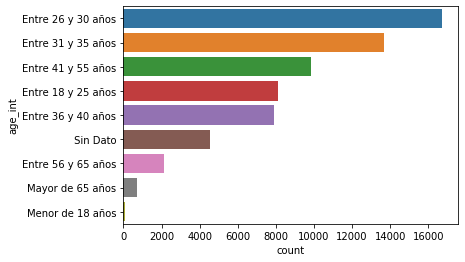

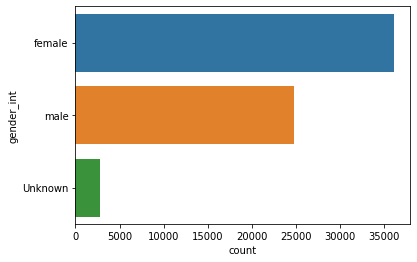

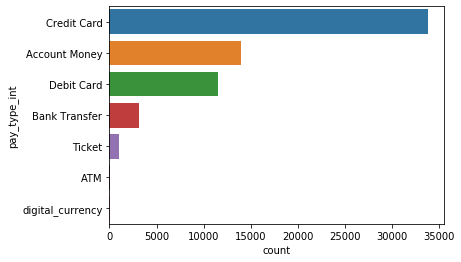

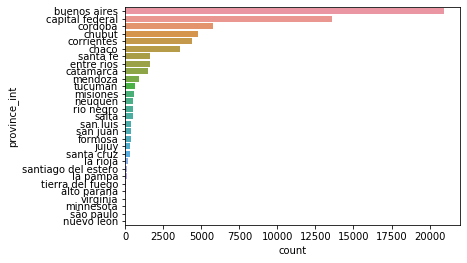

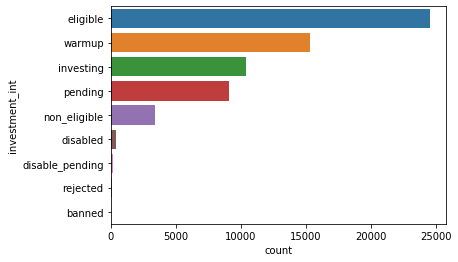

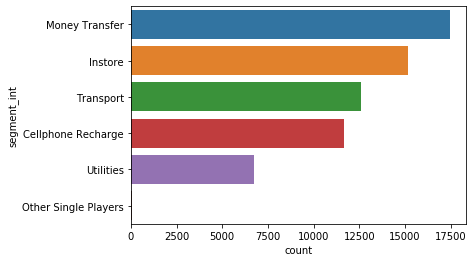

In [40]:
for cat in categorical:
    sns.countplot(y=cat, data=final_df, order=final_df[cat].value_counts().index)
    plt.show()

Our data shows the majority of our population are women, between 25-35 years old, living in Buenos Aires or CABA, which gives a strong idea that most people are concentrated in the country's center (especially since Cordoba is third). Again, the fact that province is heavily skewed towards top values makes it a strong candidate to traight up drop it.

Regarding financial data, most people use credit card as their preferred form of payments, and are eligible to invest (but are not currently doing it), which hints to them having available income to either invest or make a transaction in the next 2 months. However, that pay type is strongly unbalanced, which also makes it a candidate to drop it.

Lastly, segment shows a great deal of balance, with money transactions being the most frequent ones, and making it a useful feature in the future.

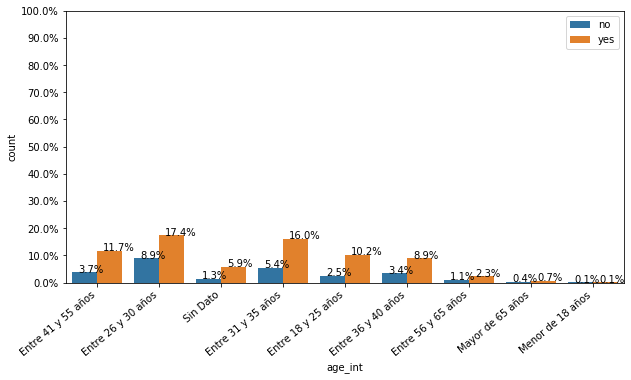

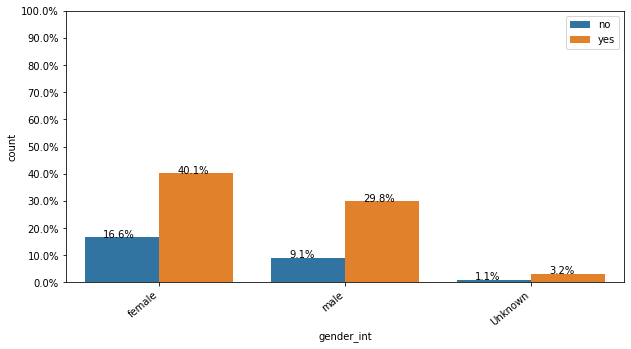

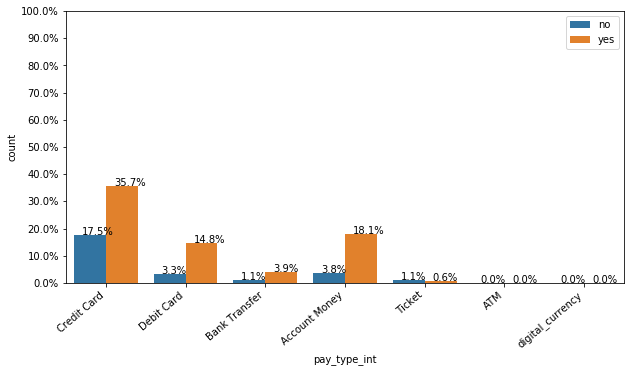

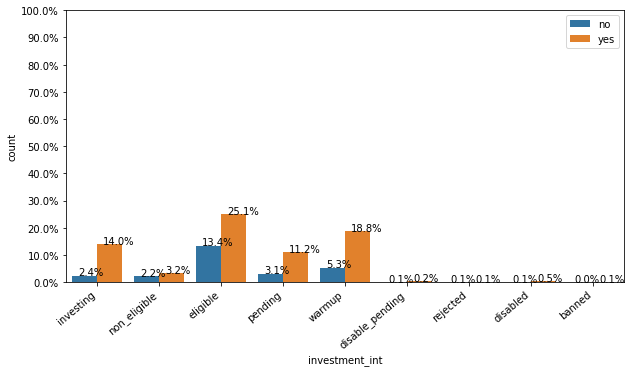

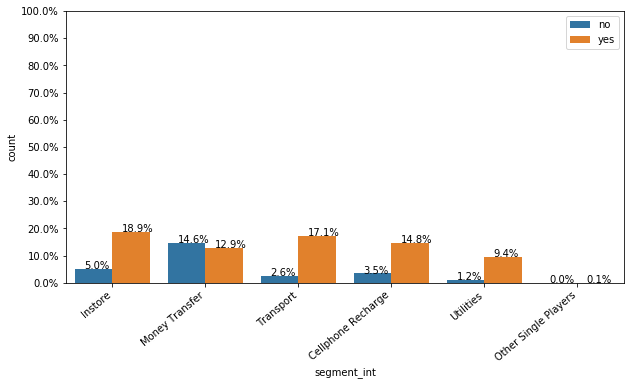

In [41]:
for cat in categorical:
    if cat == 'province_int': #too many values, will do it below
        continue
    plt.figure(figsize=(10,5))
    ax = sns.countplot(x=cat, data=final_df, hue='churn')
    for p in ax.patches:
        # Percentages on bars
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(final_df[cat])), (p.get_x()+0.1, p.get_height()+5))

    ax.yaxis.set_ticks(np.linspace(0, len(final_df[cat]), 11))

    ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/len(final_df[cat])))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
    ax.legend(labels=['no', 'yes'])
    plt.show()

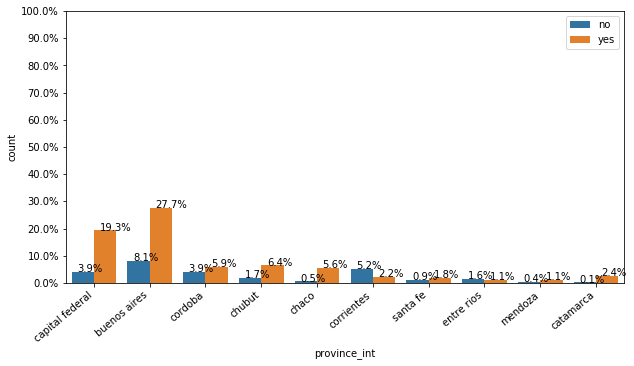

In [42]:
#Check the top 10 for ESTADO
estado_df = final_df[final_df['province_int'].isin(final_df['province_int'].value_counts().index.tolist()[:10])]
plt.figure(figsize=(10,5))
ax = sns.countplot(x='province_int', data=estado_df, hue='churn')
for p in ax.patches:
    # Percentages on bars
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(estado_df[cat])), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, len(estado_df[cat]), 11))

ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/len(estado_df[cat])))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.legend(labels=['no', 'yes'])
plt.show()

In [43]:
final_df['churn'].value_counts() * 100 / final_df.shape[0]

1    73.186858
0    26.813142
Name: churn, dtype: float64

The response label (churn) is unbalanced in favor of 1 (or Yes/True, the customer actually churning), which might cause issues when modelling. Resampling our table is not ideal, given the unbalance is not that high, and deleting or creating new data is not ideal. So, we'll just choose a proper metric in the future to account for this problem, as well as play around with class weight parameters in the models.

That also gives us an idea tu identify useful features: if we find a class inside a category with a higher percentage of 0 (or No/False), then it will be particularly useful when modelling.

The age field tends to positive churn, same as gender and investments. Payment method shows the described behaviour for the ticket class, but its too small to be relevant. Provinces show a couple of classes that might be relevant, such as Entre Rios or especially Corrientes, but we already analyzed why we might have to drop this one.

In [44]:
# Categories back to numeric data
for col, data in demo_cat_map.items():
    for code, cat in data.items():
        final_df.loc[final_df[col+'_int'] == cat, col+'_int'] = code
    final_df[col+'_int'] = final_df[col+'_int'].astype(int)

for col, data in money_cat_map.items():
    for code, cat in data.items():
        final_df.loc[final_df[col+'_int'] == cat, col+'_int'] = code
    final_df[col+'_int'] = final_df[col+'_int'].astype(int)

for code, cat in age_cat_map.items():
    final_df.loc[final_df['age_int'] == cat, 'age_int'] = code
final_df['age_int'] = final_df['age_int'].astype(int)

for col, data in pay_cat_map.items():
    for code, cat in data.items():
        final_df.loc[final_df[col+'_int'] == cat, col+'_int'] = code
    final_df[col+'_int'] = final_df[col+'_int'].astype(int)
final_df.head()

,id,churn,pa_3,pb_3,pa_2,pb_2,pa_1,pb_1,age_int,gender_int,pay_type_int,province_int,money_1,money_2,investment_int,spent_pa,discount_pa,segment_int
0,20663512,1,13,25,14,24,5,25,6,1,3,2,6935.650000,10447.870000,4,11.3566,2.2312,1
1,20663512,1,13,25,14,24,5,25,6,1,3,2,6935.650000,10447.870000,4,36.6384,0.0000,2
2,444286946,0,5,9,5,9,6,10,3,2,4,2,3692.968965,3086.271906,5,16.2064,3.8226,1
3,444286946,0,5,9,5,9,6,10,3,2,4,2,3626.798983,3027.306869,5,4.6190,0.9238,4
4,348084528,1,4,4,4,3,3,8,0,1,3,25,0.000000,0.000000,3,6.4574,0.0000,0


### Numeric Data

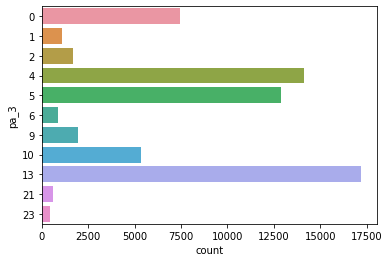

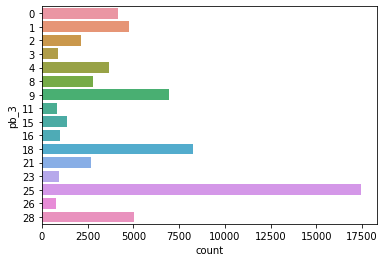

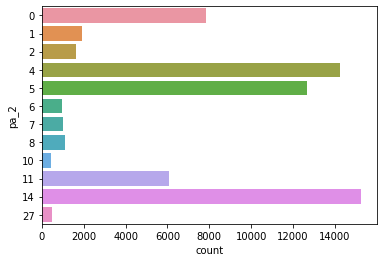

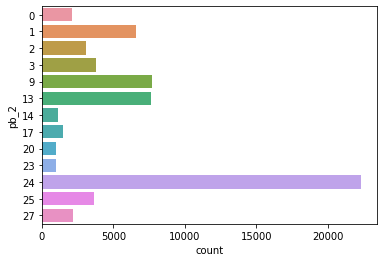

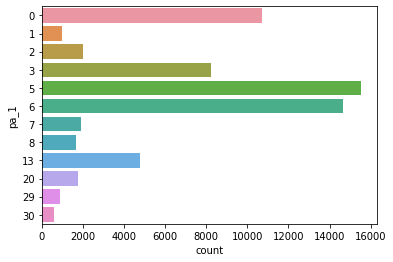

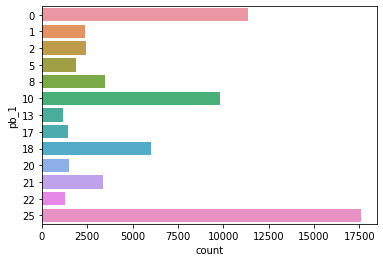

In [45]:
for num in numeric[:6]: #countplot only for discrete variables
    sns.countplot(y=final_df[num], data=final_df[num])
    plt.show()

We see the amount of times each customer has opened the platform A or B app in the last 1/2/3 months. For all cases, users seem to utilize platform B more for every month.

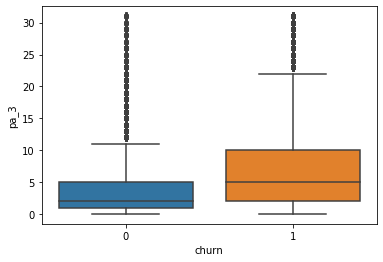

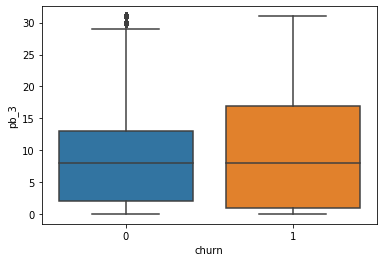

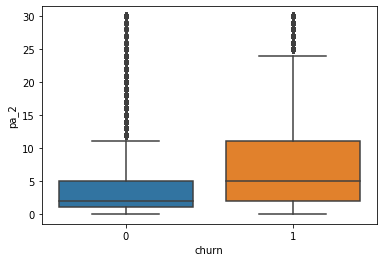

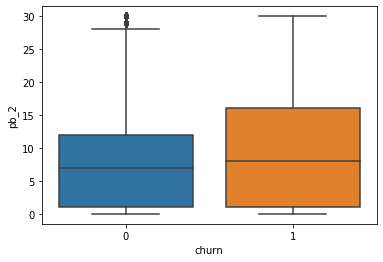

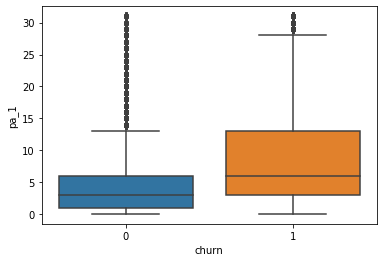

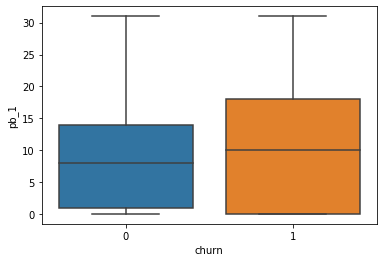

In [46]:
for num in numeric[:6]:
    sns.boxplot(data=final_df, x="churn", y=num)
    plt.show()

Boxplots show how "separated" are our data points. In general, they are within similar lines, and the height is the thing that differs beween the True/False response. However, platform B pb seems to be positioned a little bit higher, showing differences within the groups. Height is always in favour of the True response, confirming the unbalanced nature of our dataset. Moreover, platform A fields show a bigger amount of outliers, which shows there are some users using the platform a lot more than most people.

Lastly, platform A fields might be believed to spill information to the actual response, given that, the more an user opens the app, the more he's going to transact in it. This is not the case, however, due to them being based on time - they refer to the previous three months, and we are analyzing the following two. If anything, they might be important fields due to high correlation, which we are going to analyze later.

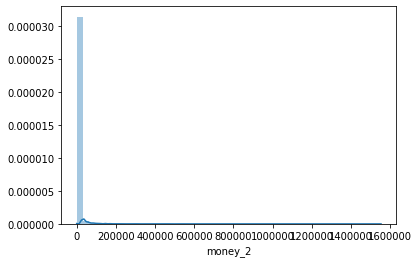

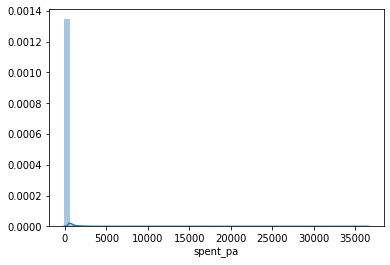

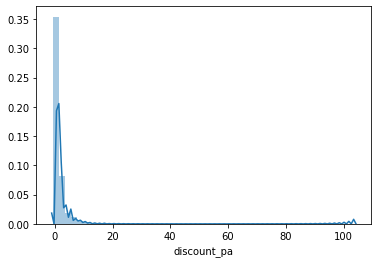

In [47]:
# Check continuous variables
for num in numeric[7:]:
    sns.distplot(final_df[num])
    plt.show()

The distributions for our continues variables are right-skewed, meaning most values are o the left side of the distribution, while the outliers are on the right. This means the money spent (be it platform A or B) or the discount are closer to 0 (in relative terms to each column, with discount not being as extreme as the other two fields).

In [48]:
aux_df = final_df.drop('id', axis=1)

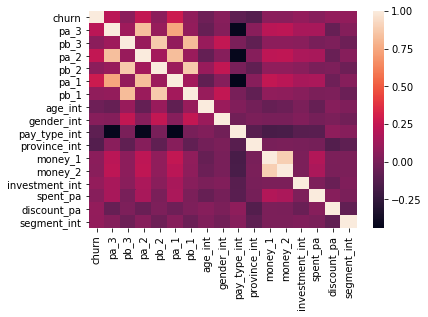

In [49]:
sns.heatmap(aux_df.corr())

In [50]:
final_df.corr()

,churn,pa_3,pb_3,pa_2,pb_2,pa_1,pb_1,age_int,gender_int,pay_type_int,province_int,money_1,money_2,investment_int,spent_pa,discount_pa,segment_int
churn,1.000000,0.219681,0.063380,0.250053,0.069911,0.279025,0.077768,-0.032665,0.050549,-0.090026,-0.126840,0.063823,0.055592,0.090385,0.049677,0.088780,0.083580
pa_3,0.219681,1.000000,0.122466,0.834807,0.103566,0.740764,0.090047,-0.062560,0.040193,-0.416272,0.054869,0.221959,0.228871,0.158045,0.155073,-0.064861,0.041506
pb_3,0.063380,0.122466,1.000000,0.107290,0.873719,0.084520,0.823862,0.106577,0.248317,0.004101,-0.083320,0.069573,0.069770,0.058357,0.000030,0.013860,-0.037065
pa_2,0.250053,0.834807,0.107290,1.000000,0.141048,0.830558,0.112251,-0.066518,0.044035,-0.425002,0.046067,0.232446,0.234778,0.169205,0.158210,-0.052997,0.045302
pb_2,0.069911,0.103566,0.873719,0.141048,1.000000,0.116881,0.875833,0.106210,0.249928,-0.001258,-0.083619,0.077379,0.076948,0.058218,0.006075,0.014998,-0.039228
pa_1,0.279025,0.740764,0.084520,0.830558,0.116881,1.000000,0.139429,-0.083525,0.043749,-0.442788,0.052341,0.245200,0.217850,0.158280,0.169321,-0.032895,0.045174
pb_1,0.077768,0.090047,0.823862,0.112251,0.875833,0.139429,1.000000,0.103624,0.248724,-0.002234,-0.076518,0.080078,0.073607,0.051564,0.008191,0.014218,-0.043246
age_int,-0.032665,-0.062560,0.106577,-0.066518,0.106210,-0.083525,0.103624,1.000000,0.109627,0.030075,-0.018930,-0.060650,-0.045862,0.009451,-0.062732,0.042696,0.019917
gender_int,0.050549,0.040193,0.248317,0.044035,0.249928,0.043749,0.248724,0.109627,1.000000,-0.021462,0.008431,0.001342,0.001050,0.028596,-0.012005,0.009396,-0.021839
pay_type_int,-0.090026,-0.416272,0.004101,-0.425002,-0.001258,-0.442788,-0.002234,0.030075,-0.021462,1.000000,-0.113874,-0.170784,-0.166470,-0.114446,-0.110245,0.074966,0.044634


The correlation table has a lot of information, so we use the heatmap to visualize it quickly. First, there are not a lot of high correlations on the entire dataset. As expected, platform A fields are strongly correlated with each other (that is pa_1, pa_2 and pa_3); and the same happens between the platform B columns. Platform B fields, however, are not really correlated with platform A, which is related to the churn we want to predict, so we might test by dropping them in the future.

Similar case for the money columns, that are correlated between each other (given the money on month -2 has a high chance of staying there until month -1). The most surprising part is that there's no correlation between what's spent by the user and the discount they receive.

Now we check the correlations in contrast to the response.

In [51]:
final_df.corr()[['churn']].sort_values('churn', ascending=False)

,churn
churn,1.000000
pa_1,0.279025
pa_2,0.250053
pa_3,0.219681
investment_int,0.090385
discount_pa,0.088780
segment_int,0.083580
pb_1,0.077768
pb_2,0.069911
money_1,0.063823


There aren't really high correlations between the churn and the rest of the fields. Discount and pa columns are the ones with the highest coefficient. This makes sense, given an user might be less inclined to use the platform when there's no discounts, and the ones that enter the app the most are the most likely to make transactions in the future. This fields will probably be the most relevant when modelling.

### Summay

We conducted an exploratory analysis of the numeric and categorical variables, checking counts, distributions, correlations, variance, etc. Among the numeric ones, we found the amount of times the users opened the platform A app and the discount might be important when modelling. On the categorical side of things, we say the province might be relevant, but the skew towards Buenos Aires makes it likely to be dropped; while the pay type and segment will be important.

On the other hand, the features to be eliminated first when modelling will be the card type, due to its low variance, or the ones related to platform B, due to low correlation to the churn.

When modelling, we'll start using every feature, and, after we found clear-cut parameters for our models, we will start the feature engineering process.

### Data Preprocessing
Necessary normalization step for the dataframe before using it in the models. We'll also define the target and the features to be used, as well as dividing the table on train and test sets for modelling (although later we will use  a more formal and complete approach to Cross Validation, such as KFold).

In [52]:
# Will normalize based on the value of the cell minus the min, divided by max minus min
def normalize(col):
    '''
    Normalizes the desired column.
    Args:
        col (str): column to normalize.
    Returns:
        Normalized value for each cell.
    '''
    
    return (col - min(col)) / (max(col) - min(col))

In [53]:
# target is churn
target = final_df['churn'].copy()

# ID is not a feature, we'll drop it
final_df.drop(['id', 'churn'], axis=1, inplace=True)

# Predictors
features = final_df.columns

In [54]:
norm_df = final_df.apply(normalize)
check_values(norm_df)

pa_3
0.000000    10662
0.161290     7716
0.064516     6791
0.032258     6522
0.096774     5463
0.129032     4051
0.193548     2798
0.225806     2390
0.258065     1921
0.290323     1691
0.322581     1459
0.354839     1337
0.387097     1057
0.419355      994
0.451613      845
0.483871      781
0.516129      699
0.548387      648
1.000000      624
0.580645      607
0.612903      511
0.645161      464
0.709677      461
0.677419      430
0.741935      419
0.838710      367
0.774194      342
0.806452      340
0.870968      335
0.967742      328
0.903226      322
0.935484      299
Name: pa_3, dtype: int64


pb_3
0.000000    12554
0.290323     5948
0.032258     4872
0.064516     4178
0.096774     1964
0.193548     1957
0.161290     1843
0.129032     1840
0.225806     1722
0.258065     1688
0.322581     1665
0.354839     1622
0.387097     1490
0.516129     1421
0.483871     1381
0.419355     1366
0.451613     1361
0.548387     1224
0.580645     1193
0.612903     1143
0.645161     1109
0.677419 

In [55]:
# Creating Train/Test data
X_train, X_test, y_train, y_test = train_test_split(norm_df, target, test_size=0.2, random_state=42)

# Model

With the exploratory analysis already finished and the table already normalized, we proceed to find the best model for the outlined problem. It's a binary classification problem, with the response somewhat unbalanced, so applying the typical algorithms for these types of problems is a good starting point:
   1. Logistic Regression.
   2. Random Forest.
   3. XGBoost.

The logistic refression is a classic model for classification due to its simplicity and quick run time. Fits the problem to a sigmoid curve, with asymptotes in 0 and 1, to determine the probabilities which are later used to define the predicted response for each observation.
   
Random Forest is about building multiple decision trees. A decision trees analyzes the features and tries to separate the response in two sides in specific points, to minimize the entropy of each split. Simply put, in each separation, each split will have the least possible mixed 1s and 0s (or True and False repsonses) to obtain a better approximation to the correct response. A Random Forest model uses many of these trees, in a parallel way (that is, at the same time) with the aim of reducing overfitting which may arise from single trees. Each tree gives a prediction for the target, and that one with the most "votes" will be the output from the Random Forest model.

Lastly, XGBoost works in a similar way, but with a very important difference: the construction of the trees is not parallel, but rather, it is sequential. That is, each tree is trained with the objective of reducing the error of the previous tree.

The metric to measure the model effectiveness will be the F1 Score, because it works well on unbalanced datasets. It measures the amount of correctly identified positive results over the total amount of identified positive results (precision), divided by the correctly identified positive results results over the number of samples that should have been identified as positive (recall). The closer the score is to one, the best the model is fitting.

F1 = 2 * (precision * recall) / (precision + recall)

We'll start by simply modelling an 80/20 train/test split and trying to optimize each model parameters. Later, we'll introduce KFold Cross Validation for the best model, to check for overfitting. Lastly, we'll try Grid Search CV to find the best parameters for the models.

In [56]:
# Model Utils
def train(model, train_features, train_target):
    '''
    Trains the desired model.
    Args:
        model (object): model to be trained.
        train_features (object): features to train it on.
        train_target (object): target to train it on.
    Returns:
        model object.
    '''
    
    model.fit(train_features, train_target)
    
    return model

def test(model, test_features, test_target, train_features, train_target):
    '''
    Tests the desired model
    Args:
        model (object): model to be trained.
        test_features (object): features to test it on.
        test_target (object): target to test it on.
        train_features (object): features to train it on.
        train_target (object): target to train it on.
    Returns:
        F1 score.
    '''
    
    test_predictions = model.predict(test_features)
    train_predictions = model.predict(train_features)
    f1_test = f1_score(test_target, test_predictions)
    f1_train = f1_score(train_target, train_predictions)

    
    print('Train F1: ', f1_train)
    print('Test F1: ', f1_test)
    
    return f1_test
    
def cross_validate(n, df, target, model): # n splits
    '''
    Runs KFold cross validation on the desired model.
    Args:
        n (int): Number of folds
        df (object): Features to apply the model.
        target (object): Target to apply the model.
        model (object): model to be trained.
    Returns:
        F1 scores of every fold
    '''
    
    f1_scores = []
    kf = KFold(n_splits=n, random_state=42)
    
    for train_index, test_index in kf.split(df):
        X_train, X_test = df.loc[train_index], df.loc[test_index]
        y_train, y_test = target.loc[train_index], target.loc[test_index]
        model = train(model, X_train, y_train)
        f1_score = test(model, X_test, y_test, X_train, y_train)
        f1_scores.append(f1_score)
    
    return f1_scores

def run_grid_search(model, params, X_train, y_train, scoring='f1', cv=3):
    '''
    Runs Grid Search CV for the desired model.
    Args:
        model (object): model to be trained.
        params (dic): parameters to run the grid search.
        train_features (object): features to train it on.
        train_target (object): target to train it on.
        scoring (str): metric of choice - default F1
        cv (str/object): number of folds - can be KFold object.
    Returns:
        Grid search object.
    '''
    
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=cv, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    return grid_search

## All Features

### Logistic Regression

In [57]:
lr = LogisticRegression(random_state=42)
lr = train(lr, X_train, y_train)
lr_f1 = test(lr, X_test, y_test, X_train, y_train)

Train F1:  0.8398345153664302
Test F1:  0.8457089113566895


The first implementation of the Logistic Regressions gives us an F1 score of 0.84 for both train and test datasets, which means there's no overfitting, and the model might be good enough to make predictions. We procceed to tune parameters to try to improve the model.

Penalty is Ridge Regression by default. C is how strong the regularization is, given by the penalty: lower C means higher regularization. Lastly, class weights determine the weights of each class, useful when the dataset is unbalanced (the balanced option automatically adjusts said weights).

In [58]:
# Introducing regularization parameter
params = [10 ** i for i in range(-4, 5)]

for c in params:
    lr = LogisticRegression(penalty="l2", C=c, class_weight=None, random_state=42)
    lr = train(lr, X_train, y_train)
    print('LR for C: ', c)
    lr_f1 = test(lr, X_test, y_test, X_train, y_train)

LR for C:  0.0001
Train F1:  0.8441474455701661
Test F1:  0.8492816481431281
LR for C:  0.001
Train F1:  0.8441474455701661
Test F1:  0.8492816481431281
LR for C:  0.01
Train F1:  0.842374628023575
Test F1:  0.8480633721733524
LR for C:  0.1
Train F1:  0.8409197670048854
Test F1:  0.8471016521982638
LR for C:  1
Train F1:  0.8398345153664302
Test F1:  0.8457089113566895


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR for C:  10
Train F1:  0.839250118652112
Test F1:  0.8451515437635729


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR for C:  100
Train F1:  0.8390589017354764
Test F1:  0.8453325774754346


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR for C:  1000
Train F1:  0.8389923069617248
Test F1:  0.8453325774754346
LR for C:  10000
Train F1:  0.83893645572326
Test F1:  0.8451143451143451


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


We don't see substantial improvement after our hyperparameter-tuning process, which might give us the idea that we need to work harder on feature selection and creation, or to straight up search for better models.

In any case, we apply KFold with our best C.

In [59]:
lr = LogisticRegression(penalty="l2", C=0.001, class_weight=None, random_state=42)
lr_f1s = cross_validate(10, norm_df, target, lr)
np.mean(lr_f1s)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train F1:  0.8445905076817612
Test F1:  0.8503339953060118
Train F1:  0.845370379698377
Test F1:  0.8433384797021161
Train F1:  0.8449747553638552
Test F1:  0.8467946396233249
Train F1:  0.8453005833341729
Test F1:  0.843968412453481
Train F1:  0.8449196783101203
Test F1:  0.8473931933381609
Train F1:  0.845024436942611
Test F1:  0.8463489762638159
Train F1:  0.8457920866859348
Test F1:  0.8396209221796975
Train F1:  0.8451757214251169
Test F1:  0.8450934155632143
Train F1:  0.845303700420113
Test F1:  0.8439400817067635
Train F1:  0.845222262523677
Test F1:  0.8447790982491155


0.84516112143857

The metric is stable and there's no overfitting. The average score is 0.8452. This is a good start, as the model is quite useful for predictions, but we might find something better.

### Random Forest

In [60]:
rf = RandomForestClassifier(random_state=42)
rf = train(rf, X_train, y_train)
rf_f1 = test(rf, X_test, y_test, X_train, y_train)

Train F1:  0.9999865600430078
Test F1:  0.9305604869388789


In [61]:
# Running CV for vanilla RF
rf = RandomForestClassifier(random_state=42)
rf_f1s = cross_validate(5, norm_df, target, rf)
np.mean(rf_f1s)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train F1:  0.9999865762802872
Test F1:  0.9286771838464287
Train F1:  0.9999731752461172
Test F1:  0.9248047373525958
Train F1:  0.9999731536417085
Test F1:  0.9287824758023433
Train F1:  0.9999732154814517
Test F1:  0.9240636223704464
Train F1:  0.9999865942757558
Test F1:  0.9285091095714652


0.9269674257886559

We start with an F1 Score of 0.9306, which stabilizs in 0.9270 and is considerably higher than the Logistic Regression. Howerver, there might be overfitting, due to the difference in scores between train and test sets. We'll try to improve this by hyperparameter tuning.

N_stimators is the amount of trees; the more trees, the better the model will learn about our data, although it becomes slower to run. Max_depth is how deep each tree is - higher depth means the model is able to better capture the difference between the data and better reduce the entropy. Min_samples_split is the minimum amount required to build brances. Min_samples_leaf is similar, but related to leaves (base of the tree). Lastly, max_features is the amount of features to consider when looking for the best split.

Since there are to many parameters to optimize, we'll use Grid Search Cross Validation, by which we'll build a grid of every possible hyperparameter and run the model for each permutation of them.

In [62]:
kf = KFold(5) #No Random State because shuffle=False

In [63]:
rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'max_depth': [5, 10, 15, 20],
    'max_features': [4, 8, 12, 16],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [200]
}

rf_grid_search = run_grid_search(rf, rf_param_grid, X_train, y_train, cv=kf)
best_rf = rf_grid_search.best_estimator_
print(rf_grid_search.best_score_)
rf_grid_search.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 36.6min finished


0.9305123408796716


{'max_depth': 15,
 'max_features': 12,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 200}

Note: Grid Search CV for Random Forest with 200 trees and cv=5 takes 60 minutes to run on a 6cores/12threads processor. The obtained parameters are:

max_depth=15, max_features=12, min_samples_leaf=1, min_samples_split=4, n_estimators=200

F1 Score is 0.9305.

Useful to build the model with these parameters instead of running the Grid Search CV every time.

In [64]:
rf = train(best_rf, X_train, y_train)
rf_f1 = test(rf, X_test, y_test, X_train, y_train)

Train F1:  0.9663298349654714
Test F1:  0.9331511563180002


We analyzed each possible combination of our Random Forest model given the parameters shown above, with a 5 Fold CV, and found the parameters outlined above. The best grid search gives us a 0.9305 score, improving over the initial 0.9269. We also reduced overfitting, and now the difference between train and test are only 3%.

For know, the model to use would be the Random Forest, as it performs better than the Logistic Regression.

### XGBoost

In [65]:
clf = xgb.XGBClassifier(random_state=42)
clf = train(clf, X_train, y_train)
clf = test(clf, X_test, y_test, X_train, y_train)

Train F1:  0.9502948609941028
Test F1:  0.931855333060891


The XGBoost model, without even tuning parameters, gives us a better result than the Logistic Regression and Random Forest, without overfitting, with an F1 score of 0.9319 (2 point difference between train and test). We'll apply KFold and then tune parameters with Grid Search CV.

In [66]:
clf = xgb.XGBClassifier(random_state=42)
clf_f1s = cross_validate(5, norm_df, target, clf)
np.mean(clf_f1s)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train F1:  0.9514477538429634
Test F1:  0.9304285273867023
Train F1:  0.9536633457866334
Test F1:  0.9272811486799444
Train F1:  0.9512801907328704
Test F1:  0.9282306468988868
Train F1:  0.9514522928898431
Test F1:  0.9254195152268488
Train F1:  0.9495903814047394
Test F1:  0.9281693777433514


0.9279058431871468

By doing 5 Fold CV, we see the score stabilizes in 0.9279, without overfitting. We proceed to use Grid Search CV.

In [67]:
clf = xgb.XGBClassifier(random_state=42)
xgb_param_grid = {
     'eta': [0.1, 0.2, 0.3] ,
     'max_depth': [5, 10, 15, 20],
     'min_child_weight': [2, 4, 6],
     'gamma': [0.0, 0.1],
     'colsample_bytree': [0.4, 0.5],
     'lambda': [1, 1.5, 2, 3]
     }

xgb_grid_search = run_grid_search(clf, xgb_param_grid, X_train, y_train, cv=kf)
best_xgb = xgb_grid_search.best_estimator_
print(xgb_grid_search.best_score_)
xgb_grid_search.best_params_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 49.1min finished


0.9321241420439688


{'colsample_bytree': 0.5,
 'eta': 0.2,
 'gamma': 0.1,
 'lambda': 2,
 'max_depth': 10,
 'min_child_weight': 2}

Note: Grid Search CV for XGBoost with 5 Folds takes 60 minutes to run on a 6cores/12threads processor. The obtained parameters are:

colsample_bytree=0.5, eta=0.2, gamma=0.1, lambda=2, max_depth=10, min_child_weight=2

F1 Score is 0.9305.

Useful to build the model with these parameters instead of running the Grid Search CV every time.

In [68]:
clf = train(best_xgb, X_train, y_train)
xgb_f1 = test(clf, X_test, y_test, X_train, y_train)

Train F1:  0.9754132884068653
Test F1:  0.9341305125453524


We found the parameters from above and an F1 score of 0.9321, superior to the Random Forest. Making and independent run with those parameters gives us an even better score of 0.9341, without overfitting. As such, XGBoost is the best model out of the 3 analyzed. In the next section, we'll proceed to create some features to see if we can improve the models even further.

### Feature Engineering

As we explained in previous sections, we could delete the columns related to Investment and Cards, since they are heavily unbalanced, tending to one specific class, giving us a very low variance.

On the other hand, we could rebuild the table by adding more features. First, we could take the average of pa/pb columns, going from 6 columns to 2, one for each platform. Same for money_ 1 and money_2.

Lastly, we could create a column that shows the difference between account money and the money spent (on any platform), giving us the available income of the customer. Problem is, said money only applies to platform A, so there would be some kind of inconsistency and creating "fake" data (for example, someone bought something but with money from another platform or account which we do not have data about, such as a debit card).

In [69]:
def trim_dfs(cols, *args):
    '''
    Deletes columns on as many DataFrames as desired.
    Args:
        cols (list): list of columns to be deleted.
        *args: DataFrames where the columns will be deleted
    Returns:
        List of columns with fixed DataFrames
    '''
    
    dfs = []
    for df in args:
        df_aux = df.drop(cols, axis=1)
        dfs.append(df_aux)
        
    return dfs

In [70]:
X_train2, X_test2 = trim_dfs(['investment_int', 'pay_type_int', 'province_int'], X_train, X_test)

In [71]:
lr = LogisticRegression(penalty="l2", C=0.001, class_weight=None, random_state=42)
lr = train(lr, X_train2, y_train)
lr_f1 = test(lr, X_test2, y_test, X_train2, y_train)

Train F1:  0.8441474455701661
Test F1:  0.8492816481431281


In [72]:
rf = train(best_rf, X_train2, y_train)
rf_f1 = test(rf, X_test2, y_test, X_train2, y_train)

Train F1:  0.9505172436004793
Test F1:  0.9065626250500199


In [73]:
clf = train(best_xgb, X_train2, y_train)
xgb_f1 = test(clf, X_test2, y_test, X_train2, y_train)

Train F1:  0.9492202185721509
Test F1:  0.9045555331586375


The Logistic Regression mantains the same values as the previous version - 0.84 score. However, we see the score goes down for the Random Forest and XGBoost models, so, the first Feature Engineering test wasn't really successful.

We go back to the original features, but only analyzing platform A (we delete everything related to platform B) for testing purposes.

In [74]:
X_train3, X_test3, norm_df3 = trim_dfs(['pb_3', 'pb_2', 'pb_1'], X_train, X_test, norm_df)

In [75]:
lr = LogisticRegression(penalty="l2", C=0.001, class_weight=None, random_state=43)
lr = train(lr, X_train3, y_train)
lr_f1 = test(lr, X_test3, y_test, X_train3, y_train)

Train F1:  0.8441474455701661
Test F1:  0.8492816481431281


In [76]:
rf = train(best_rf, X_train3, y_train)
rf_f1 = test(rf, X_test3, y_test, X_train3, y_train)

Train F1:  0.9643733845934047
Test F1:  0.9307041111167434


In [77]:
clf = train(best_xgb, X_train3, y_train)
xgb_f1 = test(clf, X_test3, y_test, X_train3, y_train)

Train F1:  0.970126343133782
Test F1:  0.9314230357416


The results are very similar, so we proceed to implement KFold CV with the best model for each case (so we do not have to run Grid Search again).

In [78]:
best_rf_f1s = cross_validate(5, norm_df3, target, best_rf)
np.mean(best_rf_f1s)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train F1:  0.965184078955912
Test F1:  0.9307951413698071
Train F1:  0.9651011935651271
Test F1:  0.9272253715336295
Train F1:  0.9644701668786172
Test F1:  0.9293967930771189
Train F1:  0.964859125750984
Test F1:  0.9294690946396512
Train F1:  0.9646189735614308
Test F1:  0.9317890637011224


0.9297350928642658

In [79]:
best_xgb_f1s = cross_validate(5, norm_df3, target, best_xgb)
np.mean(best_xgb_f1s)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train F1:  0.9703281587738258
Test F1:  0.9296035378207436
Train F1:  0.9689065627166534
Test F1:  0.9286742034943474
Train F1:  0.9688938886563416
Test F1:  0.9282159166709426
Train F1:  0.9708890225721236
Test F1:  0.925420927590125
Train F1:  0.9708046398366107
Test F1:  0.9292501549266681


0.9282329481005653

With 5 Folds, we see the average score is slightly worse than the original cases, so we are going to keep the platform B features. For Random Forest it was 0.9297 vs 0.9305 and for the XGBoost 0.8292 vs 0.9321.

Now, we take the average of the platform A, B and money feeatures, while deleting the original ones (to avoid showing repeated information).

In [80]:
X_train4 = X_train.copy()
X_train4['pa_avg'] = ((X_train4['pa_1'] + X_train4['pa_2'] + X_train4['pa_3']) / 3)
X_train4['pb_avg'] = ((X_train4['pb_1'] + X_train4['pb_2'] + X_train4['pb_3']) / 3)
X_train4['money_avg'] = ((X_train4['money_1'] + X_train4['money_2']) / 2)

X_test4 = X_test.copy()
X_test4['pa_avg'] = ((X_test4['pa_1'] + X_test4['pa_2'] + X_test4['pa_3']) / 3)
X_test4['pb_avg'] = ((X_test4['pb_1'] + X_test4['pb_2'] + X_test4['pb_3']) / 3)
X_test4['money_avg'] = ((X_test4['money_1'] + X_test4['money_2']) / 2)

norm_df4 = norm_df.copy()
norm_df4['pa_avg'] = ((norm_df4['pa_1'] + norm_df4['pa_2'] + norm_df4['pa_3']) / 3)
norm_df4['pb_avg'] = ((norm_df4['pb_1'] + norm_df4['pb_2'] + norm_df4['pb_3']) / 3)
norm_df4['money_avg'] = ((norm_df4['money_1'] + norm_df4['money_2']) / 2)

to_drop = ['pa_1', 'pa_2', 'pa_3','pb_1', 'pb_2', 'pb_3', 'money_1', 'money_2']
X_train4, X_test4, norm_df4 = trim_dfs(to_drop, X_train4, X_test4, norm_df4)

In [81]:
lr = LogisticRegression(penalty="l2", C=0.001, class_weight=None, random_state=44)
lr = train(lr, X_train4, y_train)
lr_f1 = test(lr, X_test4, y_test, X_train4, y_train)

Train F1:  0.8441474455701661
Test F1:  0.8492816481431281


In [82]:
# # Decrease max features in relative terms(12/17 to 8/11) to avoid error
rf = RandomForestClassifier(n_estimators=200, max_depth=15, max_features=8, min_samples_split=4)
rf = train(rf, X_train4, y_train)
rf_f1 = test(rf, X_test4, y_test, X_train4, y_train)

Train F1:  0.9643589543908835
Test F1:  0.9321836165356328


In [83]:
clf = train(best_xgb, X_train4, y_train)
xgb_f1 = test(clf, X_test4, y_test, X_train4, y_train)

Train F1:  0.9716608746967411
Test F1:  0.9321151490404247


In [84]:
rf = RandomForestClassifier(n_estimators=200, max_depth=15, max_features=8, min_samples_split=4)
best_rf_f1s = cross_validate(5, norm_df4, target, rf)
np.mean(best_rf_f1s)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train F1:  0.9654689142367735
Test F1:  0.9323730718153028
Train F1:  0.9651354259857119
Test F1:  0.9287682416573119
Train F1:  0.9643005288810537
Test F1:  0.9307394581381138
Train F1:  0.9648194392329887
Test F1:  0.9291645310097386
Train F1:  0.9650614276087294
Test F1:  0.9318018664752333


0.9305694338191401

The Logistic Regression and XGBoost achieve worse results, so we keep the original features. Random Forest seemed to improve, but when running KFold CV we see the average score is lower than the best XGBoost with the previous features.

The most useful feature to be created might be some kind of measurement of the available income, calculated by the amount of money in the accounts minus the money spent. Problem is, not everything that is spent goes through platform A, and such money spent occurred in May (month -1), so we would need to filter money_1 to filter said spent categories with money in account (that is Cards = Account Money = 1). However, the dataset has many different types of spending (debit, credit, transfer, etc.). We are going to partially ignore this and go ahead and create the available income as if the client has the entiriety of their money in the account.

In [85]:
X_train5 = X_train.copy()
X_test5 = X_test.copy()

X_train5['available_income'] = X_train5['money_1'] - X_train5['spent_pa']
X_test5['available_income'] = X_test5['money_1'] - X_train5['spent_pa']

X_train5, X_test5, norm_df5 = trim_dfs(['money_1', 'money_2'], X_train, X_test, norm_df)

In [86]:
lr = LogisticRegression(penalty="l2", C=0.001, class_weight=None, random_state=42)
lr = train(lr, X_train5, y_train)
lr_f1 = test(lr, X_test5, y_test, X_train5, y_train)

Train F1:  0.8441474455701661
Test F1:  0.8492816481431281


In [87]:
rf = train(best_rf, X_train5, y_train)
rf_f1 = test(rf, X_test5, y_test, X_train5, y_train)

Train F1:  0.9656875487392774
Test F1:  0.9315373708729997


In [88]:
clf = train(best_xgb, X_train5, y_train)
xgb_f1 = test(clf, X_test5, y_test, X_train5, y_train)

Train F1:  0.9713281393457676
Test F1:  0.9325630144690424


The Logistic Regression, again, shows the same results. The Random Forest and XGBoost seem to improve so we run 5 Fold CV.

In [89]:
best_rf_f1s = cross_validate(5, norm_df5, target, best_rf)
np.mean(best_rf_f1s)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train F1:  0.9664591753193591
Test F1:  0.9317264974722974
Train F1:  0.9671911747508478
Test F1:  0.9299811311132643
Train F1:  0.9660825398474948
Test F1:  0.9305074383533727
Train F1:  0.9670249873572012
Test F1:  0.930406687522437
Train F1:  0.9666883032584707
Test F1:  0.9319124955171884


0.930906849995712

In [90]:
best_xgb_f1s = cross_validate(5, norm_df5, target, best_xgb)
np.mean(best_xgb_f1s)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train F1:  0.9728992313141118
Test F1:  0.9316687217427045
Train F1:  0.971332827185381
Test F1:  0.9305213464696224
Train F1:  0.9720103781743848
Test F1:  0.9304307644914513
Train F1:  0.9730748096396891
Test F1:  0.9271495786153767
Train F1:  0.972053144839322
Test F1:  0.9305011342544854


0.9300543091147281

With CV we see the XGBoost is worse. The Random Forest improves, but it's still not as good as the original XGBoost. Furthermore, we need to keep in mind that we made a couple of strong assumptions to create this feature (in reality, not many customers have their entire money in the platform A account).

### Summary
We analyzed three models, at first with all the features, and then creating a couple and deleting others. The best model wsa the XGBoost with the original features, that gave us the following parameters:
   1. colsample_bytree: 0.5
   2. eta: 0.2
   3. gamma: 0.1
   4. max_depth: 10
   5. min_child_weight: 2
   6. lambda: 2
   
Feature engineering was useful to validate the score against changes in the table, but was not particularly successful in finding a better result or model. This was not the case for hyper parametrization, which gave us a significant improvement in our scores (thanks to Grid Search CV).

The actual score was 0.9342 for a particular train/test split, and an average of 0.9321 in a 5 Fold CV.   

We are goint to finish the project by creating a prediction column and assigning it to the original table.

In [91]:
# test preds
clf = train(best_xgb, X_train, y_train)
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)
print('Train F1: ', f1_score(y_train, preds_train))
print('Test F1: ', f1_score(y_test, preds_test))

Train F1:  0.9754132884068653
Test F1:  0.9341305125453524


In [92]:
X_train_preds = X_train.copy()
X_train_preds['churn_pred'] = preds_train

X_test_preds = X_test.copy()
X_test_preds['churn_pred'] = preds_test

In [94]:
og_df

,id,churn,pa_3,pb_3,pa_2,pb_2,pa_1,pb_1,age_int,gender_int,pay_type_int,province_int,money_1,money_2,investment_int,spent_pa,discount_pa,segment_int,churn_pred
0,20663512,1,13,25,14,24,5,25,Entre 41 y 55 años,female,Credit Card,capital federal,6935.650000,10447.870000,investing,11.356600,2.231200,Instore,1.0
1,20663512,1,13,25,14,24,5,25,Entre 41 y 55 años,female,Credit Card,capital federal,6935.650000,10447.870000,investing,36.638400,0.000000,Money Transfer,1.0
2,444286946,0,5,9,5,9,6,10,Entre 26 y 30 años,male,Debit Card,capital federal,3692.968965,3086.271906,non_eligible,16.206400,3.822600,Instore,0.0
3,444286946,0,5,9,5,9,6,10,Entre 26 y 30 años,male,Debit Card,capital federal,3626.798983,3027.306869,non_eligible,4.619000,0.923800,Transport,0.0
4,348084528,1,4,4,4,3,3,8,Sin Dato,female,Credit Card,são paulo,0.000000,0.000000,eligible,6.457400,0.000000,Cellphone Recharge,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63669,35688803,1,1,12,0,20,0,22,Entre 31 y 35 años,female,Credit Card,formosa,0.000000,0.000000,eligible,51.820400,0.000000,Instore,1.0
63670,384904109,0,1,5,0,4,0,4,Entre 26 y 30 años,female,Credit Card,corrientes,0.000000,0.000000,eligible,22.500096,0.824763,Money Transfer,0.0
63671,403313804,0,5,9,5,9,6,10,Entre 26 y 30 años,female,Credit Card,corrientes,0.000000,0.000000,eligible,74.544089,0.714365,Money Transfer,0.0
63672,307339795,0,3,0,1,0,2,0,Entre 41 y 55 años,female,Credit Card,buenos aires,0.000000,0.000000,eligible,33.065628,1.073004,Money Transfer,0.0


In [95]:
og_df.loc[X_train_preds.index, 'churn_pred'] = X_train_preds['churn_pred']
og_df.loc[X_test_preds.index, 'churn_pred'] = X_test_preds['churn_pred']

# Reordering
og_df = og_df[['id', 'pa_3', 'pb_3', 'pa_2', 'pb_2', 'pa_1', 'pb_1', 'age_int', 'gender_int', 'pay_type_int',
               'province_int', 'money_1', 'money_2', 'investment_int', 'spent_pa', 'discount_pa', 'segment_int',
               'churn', 'churn_pred']]

og_df['churn_pred'] = og_df['churn_pred'].astype(int)

In [96]:
og_df['churn'].value_counts() * 100 / og_df.shape[0]

1    73.186858
0    26.813142
Name: churn, dtype: float64

In [97]:
og_df['churn_pred'].value_counts() * 100 / og_df.shape[0]

1    76.866539
0    23.133461
Name: churn_pred, dtype: float64

When checking a simple ratio comparison between originals and predictions, we see the they are very close: from around 73/26 to 76/23 respectively, which means the model is fitting well.

On the other hand, the original file (with the target information) only had 43502 rows, witha  65/35 split. However, when joining columns such as state or segment, we duplicate clients (although the actual data is different, as one client may have been in different provinces, for example). Said columns can't be deleted because they provide valuable information. That's why we end up with more than 60000 rows and a 73/26 split.

The first fix we implemented was using Hot Encoding (dummies) instead of Label Encoding for such columns - that is, creating a column for each class in each categorical column, and assigning 1 or 0 depending if the class was present for that user or not. However, the prediction capabilities of the models were significantly lower, with the best result being 0.90. This is not shown in this present notebook, as to avoid confusing information that did not end up in our models.

So, they way to fix it is grouping by client and sum the predictions. If the sum is 0, then the client never had a 1 predicted, so it stays as a 0. Otherwise, if it is 1 or more, then it means at least in one row it was predicted as 1, so it will be labeled as 1 (which means, they will keep using platform A).

In [98]:
og_df_trim = og_df[['id', 'churn', 'churn_pred']].copy()
to_export = og_df_trim.groupby('id', as_index=False).sum()
to_export

,id,churn,churn_pred
0,100006392,1,1
1,100007165,2,2
2,100007237,0,0
3,100007543,2,2
4,100007761,1,1
...,...,...,...
43497,99971137,1,1
43498,99977179,1,1
43499,9998207,0,0
43500,99993131,1,1


In [99]:
# If result is 1 or higher, it means at least one instance was predicted as 1, so we'll classify it as 1
for i in range(1, 6):
    to_export['churn'].replace(i, 1, inplace=True)
    to_export['churn_pred'].replace(i, 1, inplace=True)
    
print(to_export['churn'].value_counts() * 100 / to_export.shape[0])
print(to_export['churn_pred'].value_counts() * 100 / to_export.shape[0])

1    64.13958
0    35.86042
Name: churn, dtype: float64
1    69.127856
0    30.872144
Name: churn_pred, dtype: float64


With said adjustment, we go frmo a 65/35 split in favor to 1 in the original target file to predictions of 60/30 from our model, which means it's fitting quite well.

Al hacer el ajuste de clientes, pasamos de un 65/35 en favor del 1 a un 60/30 con las predicciones del modelo, por lo que el split se mantuvo a similar cercanía que con el dataframe anterior de más de 60000 filas.

In [100]:
## UNCOMMENT IF YOU WANT TO EXPORT THE RESULTS
# to_export.to_excel('predicted_churn.xlsx', index=False)

# Conclusión

Starting from 6 different tables, we created a big dataset with different types of fields for each client, such as transactional, financial, demographic or behavioural data. We followed up with an exploratory analysis to find patterns and correlations, visualize effects and atributes, among other things. We found relevant columns and created a couple hypothesis about which ones to use and which ones to delete, only to end up rejecting them after analyzing our results.

Afterwards, we starting modelling, using Logistic Regression, Random Forest and XGBoost. Post hyper-parametrization for each of them, and after many tests regarding input tables, we concluded the XGBoost with the original dataset gave us the best results, so it was used to create the predictive table. Said table had a couple of things to note regarding data quality and duplicates, where we had to make a couple of important decisions regarding methodology (already explained in the "Summary" section(.

So, after our statistical analysis and our modelling, which economic or business effects could this type of project have? First, we found a segment of 30% of clients that we are predicting they will stop using our platform. Second, we found they strongly respond to discounts. So, to keep these users in our platform, we could try to stablish a more frequent discount policy on different areas of the platform, such as paying bills, for example.
 
Moreover, we also found a trong correlation between the amount of times the App was used and the response. Even if it seems there's some kind of "spill" effect of this information to the response, there's actually none, since said data corresponds to the previous three months, and we are predicting the following two. As such, incentivizing the use of the app by adding functionalities might be a step in the right direction. Coupling it with a marketing campaign to show those new features might go even further in retaining the users.

In conclusion, we predict 30% of the users won't make any transactions in the following two months on platform A. Introducing discounts or new features, as well as strong marketing campaings, might help reduce this number by incentivizing users to keep using our app.